In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install -q kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle (1).json
-rw-r--r-- 1 root root 68 Apr 20 08:30 kaggle.json
/content
403 - Forbidden - Permission 'datasets.get' was denied


In [ ]:
!kaggle datasets download -d prasoonkottarathil/face-mask-lite-dataset

100% 23.3G/23.3G [04:26<00:00, 122MB/s]
100% 23.3G/23.3G [04:26<00:00, 93.8MB/s]


In [ ]:
!unzip face-mask-lite-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: without_mask/seed5000.png  
  inflating: without_mask/seed5001.png  
  inflating: without_mask/seed5002.png  
  inflating: without_mask/seed5003.png  
  inflating: without_mask/seed5004.png  
  inflating: without_mask/seed5005.png  
  inflating: without_mask/seed5006.png  
  inflating: without_mask/seed5007.png  
  inflating: without_mask/seed5008.png  
  inflating: without_mask/seed5009.png  
  inflating: without_mask/seed5010.png  
  inflating: without_mask/seed5011.png  
  inflating: without_mask/seed5012.png  
  inflating: without_mask/seed5013.png  
  inflating: without_mask/seed5014.png  
  inflating: without_mask/seed5015.png  
  inflating: without_mask/seed5016.png  
  inflating: without_mask/seed5017.png  
  inflating: without_mask/seed5018.png  
  inflating: without_mask/seed5019.png  
  inflating: without_mask/seed5020.png  
  inflating: without_mask/seed5021.png  
  inflating: without_mask/seed5022.png  
  infl

In [ ]:
!rm -rf /content/with_mask
!rm -rf /content/face-mask-lite-dataset.zip

<h1>GAN (Generative Adversarial Network)</h1>

<h3>A GAN consists of two neural networks competing against each other - a generator and a discriminator. The generator network takes in random noise as input and generates fake data samples, such as images, text, or audio, trying to mimic the real data distribution. The discriminator network, on the other hand, takes in both real data samples and the fake samples generated by the generator, and tries to distinguish between them.</h3>

<h3>The training process involves an adversarial game between the two networks. The generator aims to generate fake samples that are indistinguishable from real data, fooling the discriminator. The discriminator, in turn, tries to accurately identify the real and fake samples. This adversarial training process continues iteratively, with the generator improving its ability to generate realistic samples, and the discriminator becoming better at distinguishing real from fake data.</h3>

<h3>Mathematically, the generator network learns a mapping function from the input noise to the output data distribution, G: Z → X, where Z is the noise space, and X is the data space. The discriminator network learns to estimate the probability that a given sample came from the real data distribution, D: X → [0, 1].</h3>

<h3>During training, the generator tries to minimize the probability that the discriminator can correctly identify its fake samples, while the discriminator tries to maximize its ability to distinguish real from fake samples. This can be expressed as a minimax game, where the generator and discriminator play the following two-player minimax game</h3>

<h2>Importing Libraries</h2>

In [ ]:
# Importing necessary libraries
import tensorflow as tf  # TensorFlow library for deep learning
import keras  # Keras high-level neural networks API
from keras import layers  # Keras layers for building neural network models
import numpy as np  # NumPy library for numerical computations
import matplotlib.pyplot as plt  # Matplotlib library for plotting
import cv2  # OpenCV library for image processing
import os  # Operating system module for file operations
from tqdm import tqdm  # tqdm library for progress bars
import re  # Regular expressions module for string processing
from keras.preprocessing.image import img_to_array  # Convert images to NumPy arrays
import time  # Time module for measuring execution time

<h2>Defining the constants</h2>

In [ ]:
#  Define the image size
SIZE = 128
_img = []
# Path to the image dataset
path= '../content/without_mask/'
# Path to save model checkpoints
checkpoint_dir = '/content/training_checkpoints/'
# Path for saving final model
model_save_dir = '/content/models/'
# List all the files in the directory
files = os.listdir(path)
# Define batch size
batch_size = 32
# Dimension of the latent space
latent_dim = 100
# No. of epochs
epochs =50

<h2>Managing the files, to store the images in an array</h2>

In [ ]:
def sorted_alphanumeric(data):
    """
    Sorts a list of the string alphanumerically.

    Args:
        data (list): List of the strings tobe sorted.

    Returns:
        list: Alphanumerically sorted list of strings.
    """

    # Checks if the string is a number and converts it to integer for sorting
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    # Split the string into a list of string and numbers
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    # Returns the sorted list of strings
    return sorted(data, key=alphanum_key)

In [ ]:
# Listing all the files in the alphanumerically sorted order
files = sorted_alphanumeric(files)

In [ ]:
# Iterate through files with a progress bar
for i in tqdm(files):
    # Read image using OpenCV
    img = cv2.imread(path+'/'+i, 1)  # 1 for color image
    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize image to specified dimensions
    img = cv2.resize(img, (SIZE, SIZE))
    # Normalize pixel values to range [-1, 1]
    img = (img - 127.5) / 127.5
    # Convert image to float datatype
    imh = img.astype(float)
    # Convert image to array and append to list
    _img.append(img_to_array(img))

100%|██████████| 10000/10000 [09:21<00:00, 17.80it/s]


<h2>Displaying sample input data</h2>

<ipython-input-16-5cbccb174603>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr, sqr, i+1)


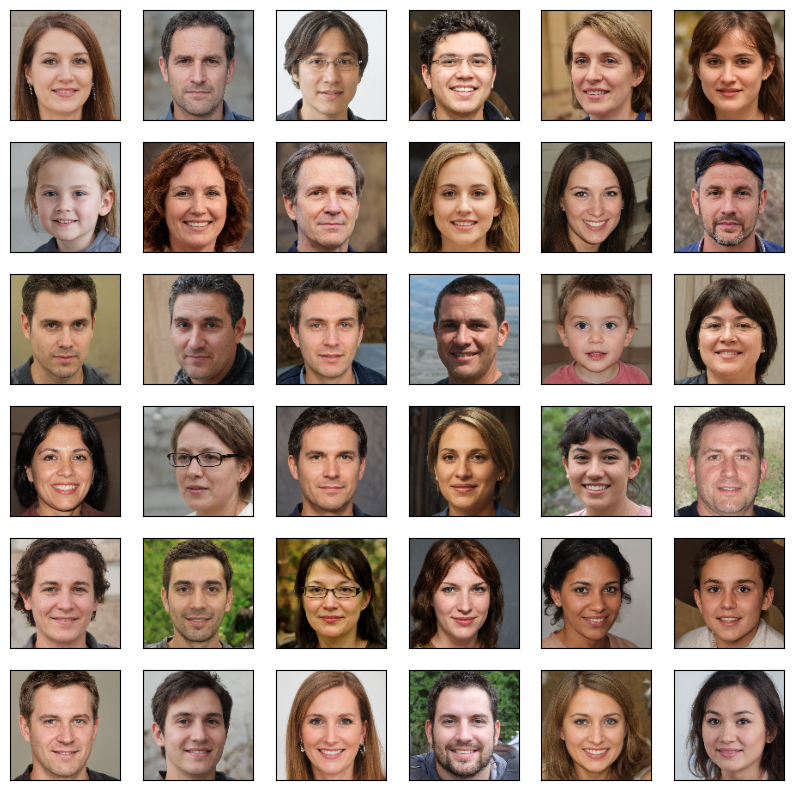

In [ ]:
def plot_images(sqr=5):
    """
    Plot images from _img list.

    Args:
        sqr (int): Number of images per row/column in the plot grid. Default is 5.
    """
    # Create a new figure with a specified size
    plt.figure(figsize=(10, 10))
    # Set the title of the plot
    plt.title("Real Images")

    # Iterate through each subplot
    for i in range(sqr*sqr):
        # Create a subplot in the grid
        plt.subplot(sqr, sqr, i+1)
        # Display an image in the subplot, adjusting pixel values to range [0, 1]
        plt.imshow(_img[i]*0.5 + 0.5)
        # Remove x-axis ticks
        plt.xticks([])
        # Remove y-axis ticks
        plt.yticks([])

# Call the function to plot images in a grid with 6 images per row/column
plot_images(6)

<h2>Creating dataset by help of the tensorflow dataset</h2>

In [ ]:
# Create a TensorFlow dataset from the _img list
# tf.data.Dataset.from_tensor_slices creates a dataset with one element for each row of the input tensor
# np.array(_img) converts the _img list into a numpy array
# .batch() batch the dataset into smaller batches
dataset = tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

<h2>Building up the structure of the GAN (Generative Adversarial Networks) model</h2>

<h4>Defining the structure of the generator</h4>

In [ ]:
def Generator():
    # Define a sequential model
    model = tf.keras.Sequential()

    # Add a fully connected layer with no bias, mapping from latent space to 128*128*3 dimensions
    model.add(keras.layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim, )))
    # Reshape the output to a 128x128x3 image tensor
    model.add(keras.layers.Reshape((128, 128, 3)))

    # Downsampling layers
    # Convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2D(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    # More convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    # Upsampling layers
    # Transposed convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.LeakyReLU())

    # More transposed convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())

    # Final convolutional layers to generate the output image
    model.add(keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(3, 4, strides=1, padding='same', activation='tanh'))

    return model

<h4>Creating a instance of the generator and printing out the summary of the generator</h4>

In [ ]:
# Creates a generator model
generator = Generator()

# Prints a summary of the generator model
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                        

<h4>Defining the structure of the discriminator</h4>

In [ ]:
def Discriminator():
    # Create a sequential model for the discriminator
    model = keras.models.Sequential()

    # Input layer specifying the size of input images
    model.add(keras.layers.Input((SIZE, SIZE, 3)))

    # Convolutional layer with 128 filters, 4x4 kernel size, and 2x2 stride
    model.add(keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())  # Batch normalization for stable training
    model.add(keras.layers.LeakyReLU())  # LeakyReLU activation for introducing non-linearity

    # More convolutional layers with similar configurations
    model.add(keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.LeakyReLU())

    # Flatten the output to feed into a dense layer
    model.add(keras.layers.Flatten())

    # Final dense layer with sigmoid activation, outputting a single value (0 or 1) for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

<h4>Creating a instance of the generator and printing out the summary of the discriminator</h4>

In [ ]:
# Create an instance of the discriminator model
discriminator = Discriminator()

# Print a summary of the discriminator model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_5 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)      

<h2>Plotting noise generated image by generator before training<h2>

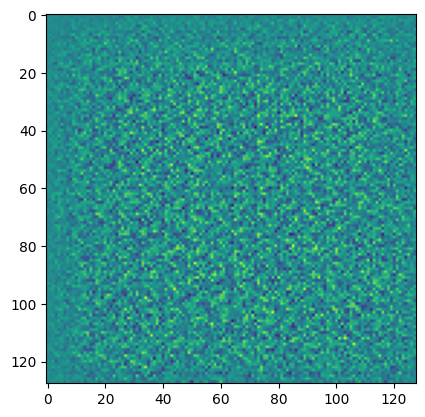

In [ ]:
# Generate random noise using NumPy
noise = np.random.normal(-1, 1, (1, 100))  # Shape: (1, 100)

# Generate an image using the generator model
img = generator(noise)  # Pass the noise through the generator model to generate an image

# Display the generated image
plt.imshow(img[0, :, :, 0])  # Show the first channel of the generated image (assuming it's a grayscale image)
plt.show()

<h2>Defining loss function and optimizer</h2>

In [ ]:
# Define the RMSprop optimizer for the generator model
optimizer_generator = keras.optimizers.Adam(
    learning_rate=0.0001,  # Learning rate for the optimizer
    clipvalue=1.0,          # Clip gradients to a maximum of 1.0 to prevent exploding gradients
)

# Define the RMSprop optimizer for the discriminator model
optimizer_discriminator = keras.optimizers.Adam(
    learning_rate=0.0001,  # Learning rate for the optimizer
    clipvalue=1.0,          # Clip gradients to a maximum of 1.0 to prevent exploding gradients
)

# Define the binary cross-entropy loss function for training the models
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

<h4>Defining custom functions for managing the generator and discriminator loss</h4>

<h3>In a Generative Adversarial Network (GAN), the discriminator network is trained to distinguish between real and fake (generated) images. The goal is to maximize the discriminator's ability to correctly classify real images as real (label 1) and fake images as fake (label 0).

To achieve this, we need to compute two separate losses:

Fake Loss: This loss measures how well the discriminator classifies the fake (generated) images as fake. We want the discriminator to output values close to 0 for fake images, indicating that it has correctly identified them as fake. In the code snippet, tf.zeros_like(fake_output) creates a tensor filled with zeros of the same shape as fake_output. This tensor represents the desired output of the discriminator for fake images (0 = fake). The cross_entropy function then computes the loss between this desired output (tf.zeros_like(fake_output)) and the actual output of the discriminator for the fake images (fake_output).

Real Loss: This loss measures how well the discriminator classifies the real images as real. We want the discriminator to output values close to 1 for real images, indicating that it has correctly identified them as real. In the code snippet, tf.ones_like(real_output) creates a tensor filled with ones of the same shape as real_output. This tensor represents the desired output of the discriminator for real images (1 = real). The cross_entropy function then computes the loss between this desired output (tf.ones_like(real_output)) and the actual output of the discriminator for the real images (real_output).</h3>

In [ ]:
def generator_loss(fake_output):
    """
    Computes the loss for the generator.

    Args:
        fake_output: Output of the discriminator when given generated images.

    Returns:
        The generator loss value.
    """
    # Use binary cross-entropy loss to measure the difference between the discriminator's output and ones (real labels)
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_loss(fake_output, real_output):
    """
    Computes the loss for the discriminator.

    Args:
        fake_output: Output of the discriminator when given generated images.
        real_output: Output of the discriminator when given real images.

    Returns:
        The discriminator loss value.
    """
    # Compute the loss for fake images by comparing the discriminator's output with zeros (fake labels)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Compute the loss for real images by comparing the discriminator's output with ones (real labels)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # The total discriminator loss is the sum of the losses for fake and real images
    return fake_loss + real_loss


<h2>Defining the training steps functions for gradient stepping and loss back propagation</h2>

In [ ]:
def train_steps(images):
    # Generate random noise for the generator input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images using the generator
        generated_images = generator(noise)

        # Get discriminator outputs for generated and real images
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        # Calculate generator and discriminator losses
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Compute gradients of generator and discriminator losses with respect to trainable variables
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Apply gradients to update the generator and discriminator parameters using their respective optimizers
    optimizer_generator.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    optimizer_discriminator.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    # Return the computed losses for monitoring
    loss = {'gen loss': gen_loss,
            'disc loss': dis_loss}
    return loss

<h2>Function for generaring new images from normal distribution having mean 0 and standard deviation 1 and ploting generated images</h2>

In [ ]:
def plot_generated_images(square=5, epochs=0):
    """
    Plot generated images using the trained generator model.

    Args:
        square (int): Number of images per row/column in the plot grid. Default is 5.
        epochs (int): Current epoch number for display in the plot title. Default is 0.
    """
    # Create a new figure for plotting
    plt.figure(figsize=(10, 10))

    # Iterate through each subplot in the grid
    for i in range(square*square):
        # Add a title to the plot if the epoch number is provided and it's the middle subplot
        if epochs != 0:
            if(i == square//2):
                plt.title("Generated images at Epoch: {}\n".format(epochs))

        # Create random noise for generating an image
        noise = np.random.normal(0, 1, (1, latent_dim))

        # Generate an image using the generator model
        img = generator(noise)

        # Clip pixel values to [0, 1] range and plot the image
        plt.imshow(np.clip((img[0, ...]+1)/2, 0, 1))

        # Remove x-axis ticks
        plt.xticks([])
        # Remove y-axis ticks
        plt.yticks([])
        # Display grid lines for visual clarity
        plt.grid()


<h2>Defining the outer function for training  of GAN (generator and discriminator)</h2>

In [ ]:
def train(epochs, dataset, checkpoint_dir):
    """
    Train the GAN model for a specified number of epochs using the given dataset.

    Args:
        epochs (int): Number of epochs for training.
        dataset (tf.data.Dataset): Input dataset for training.
        checkpoint_dir (str): Directory to save checkpoints.

    Returns:
        dict: History of generator and discriminator losses during training.
    """
    # Lists to store generator and discriminator losses for each epoch
    gen_losses = []
    disc_losses = []

    # Create a checkpoint manager to save checkpoints
    checkpoint = tf.train.Checkpoint(generator=generator,
                                     discriminator=discriminator,
                                     optimizer=optimizer_generator,
                                     optimizer_discriminator=optimizer_discriminator)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

    # Define a variable to track the lowest discriminator loss
    lowest_disc_loss = float('inf')

    # Iterate over each epoch
    for epoch in range(epochs):
        start = time.time()  # Record start time of the epoch
        print("\nEpoch: {}".format(epoch+1))

        # Iterate over batches of images in the dataset
        for images in dataset:
            # Perform one training step for the GAN
            loss = train_steps(images)

        # Calculate and print epoch duration
        epoch_time = np.round(time.time() - start, 2)
        print("Time taken for epoch: {} seconds".format(epoch_time))

        # Print generator and discriminator losses for the epoch
        print("Generator loss: {} | Discriminator loss: {}".format(loss['gen loss'], loss['disc loss']))

        # Append the losses to the respective lists for tracking
        gen_losses.append(loss['gen loss'])
        disc_losses.append(loss['disc loss'])

        # Check if the current discriminator loss is the lowest so far, If it is then save the model
        if loss['disc loss'] < lowest_disc_loss:
            lowest_disc_loss = loss['disc loss']
            checkpoint_manager.save()  # Save the model with the lowest loss

    # Store the training history as a dictionary
    history = {'gen_losses': gen_losses, 'disc_losses': disc_losses}

    return history


<h4>Saving the history of the model training in the history variable</h4>

In [ ]:
# Staert training of the GAN model (generator and discriminator) and store the training history (losses) in the history dictionary
history = train(epochs, dataset, checkpoint_dir)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time taken for epoch: 733.51 seconds
Generator loss: 1.7104524374008179 | Discriminator loss: 0.40278270840644836

Epoch: 2
Time taken for epoch: 689.73 seconds
Generator loss: 6.141417980194092 | Discriminator loss: 0.20289422571659088

Epoch: 3
Time taken for epoch: 741.91 seconds
Generator loss: 12.199226379394531 | Discriminator loss: 0.14978690445423126

Epoch: 4
Time taken for epoch: 690.19 seconds
Generator loss: 2.429734230041504 | Discriminator loss: 0.9033462405204773

Epoch: 5
Time taken for epoch: 687.59 seconds
Generator loss: 16.462989807128906 | Discriminator loss: 0.0015851204516366124

Epoch: 6
Time taken for epoch: 666.23 seconds
Generator loss: 12.586241722106934 | Discriminator loss: 6.139477591204923e-06

Epoch: 7
Time taken for epoch: 663.56 seconds
Generator loss: 11.271857261657715 | Discriminator loss: 1.3333243259694427e-05

Epoch: 8
Time taken for epoch: 663.84 seconds
Generator loss: 10.843685150146484 | Discriminator loss: 1.974876067833975e-05

Epoch: 9
Ti

<h2>Saving the final models (generator and discriminator)</h2>

In [ ]:
# Save the generator model to the specified location
generator.save(f'{model_save_dir}generator.keras')

# Save the discriminator model to the specified location
discriminator.save(f'{model_save_dir}discriminator.keras')

<h2>Showing the pairs of the four images generated by the random noise from the normal distribution</h2>

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

<h2>Showing 49 images generated by the random noise from the normal distribution</h2>

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(7)

<h2>Plotting the loss of the genertor and discriminator</h2>

In [ ]:
def plot_losses(history):
    """
    Plot generator and discriminator losses over epochs.

    Args:
        history (dict): Dictionary containing generator and discriminator losses for each epoch.
    """
    # Create a new figure for plotting
    plt.figure(figsize=(10, 6))

    # Plot generator loss over epochs
    plt.plot(history['gen_losses'], label='Generator Loss')

    # Plot discriminator loss over epochs
    plt.plot(history['disc_losses'], label='Discriminator Loss')

    # Add labels and title to the plot
    plt.xlabel('Epoch')  # X-axis label
    plt.ylabel('Loss')   # Y-axis label
    plt.title('Generator and Discriminator Losses')  # Plot title

    # Add legend to distinguish between generator and discriminator losses
    plt.legend()

    # Display the plot
    plt.show()

plot_losses(history)